# GPLVM

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Bernoulli, MultivariateNormalTriL, Normal
from edward.util import rbf
from observations import crabs
from sklearn.decomposition import PCA
import scipy.io

In [2]:
# def const(x):
#     x = tf.constant(x,dtype=tf.float32)
#     return x

# plt.subplots(2,3,figsize=(10,6))

# def build_toy_dataset(N, D, K, Ngrid = 100, prior_l=2, prior_sig_f=1, l=0.5, sig_f=1, sig_n=1e-1):
#     Nall = Ngrid + N
#     tgrid = np.linspace(-5, 5, num=N).reshape(-1,1)

#     sess = ed.get_session()
#     with sess.as_default():
#         Kprior = rbf(const(tgrid),lengthscale=const(prior_l),variance=const(prior_sig_f)).eval()

#     z_mu = np.zeros(N)
#     z_cov = Kprior + 1e-10*np.eye(N)
#     z = np.random.multivariate_normal(z_mu, z_cov).T.reshape(-1,1)
#     zgrid = np.linspace(z.min(), z.max(), num=Ngrid).reshape(-1,1)
#     zall = np.vstack((z,zgrid))

#     plt.subplot(2,3,1)
#     plt.imshow(Kprior)
#     plt.colorbar()
#     plt.subplot(2,3,2)
#     plt.plot(z)

#     with sess.as_default():
#         Kzall = rbf(const(zall),lengthscale=const(l),variance=const(sig_f)).eval()

#     Kz = Kzall[:N,:N]
#     xall = np.random.multivariate_normal(np.zeros(Nall), Kzall, D).T
#     x = xall[:N,:]
#     xgrid = xall[N:,:]
#     noise = np.random.randn(x.shape[0],x.shape[1])
#     x = x + sig_n*noise

#     plt.subplot(2,3,4)
#     plt.imshow(Kz)
#     plt.colorbar()
#     plt.subplot(2,3,5)
#     plt.imshow(np.cov(x))
#     plt.colorbar()
#     plt.subplot(2,3,6)
#     plt.plot(xgrid[:,:5])

#     return x,xgrid,z,zgrid,tgrid,Kz,Kprior

# N = 500  # number of data points, number of time points
# D = 200  # data dimensionality, number of neurons
# K = 1  # latent dimensionality

# x_true, xgrid, z_true, zgrid, tgrid, Kz_true, Kprior_true = build_toy_dataset(N, D, K)

# print("Number of data points N={}".format(N))
# print("Number of features D={}".format(D))
# print("Number of latent dimensions K={}".format(K))

# pca = PCA(n_components=1)
# z_init = pca.fit_transform(x_true)

# # visualize the covariance of Z
# plt.subplot(2,3,3)
# plt.plot(z_init)

# scipy.io.savemat('syn.mat',mdict={'x_true':x_true, 'xgrid':xgrid, 'z_true':z_true, 'zgrid':zgrid, 
#                                   'tgrid':tgrid, 'Kz_true':Kz_true, 'Kprior_true':Kprior_true})

<IPython.core.display.Javascript object>


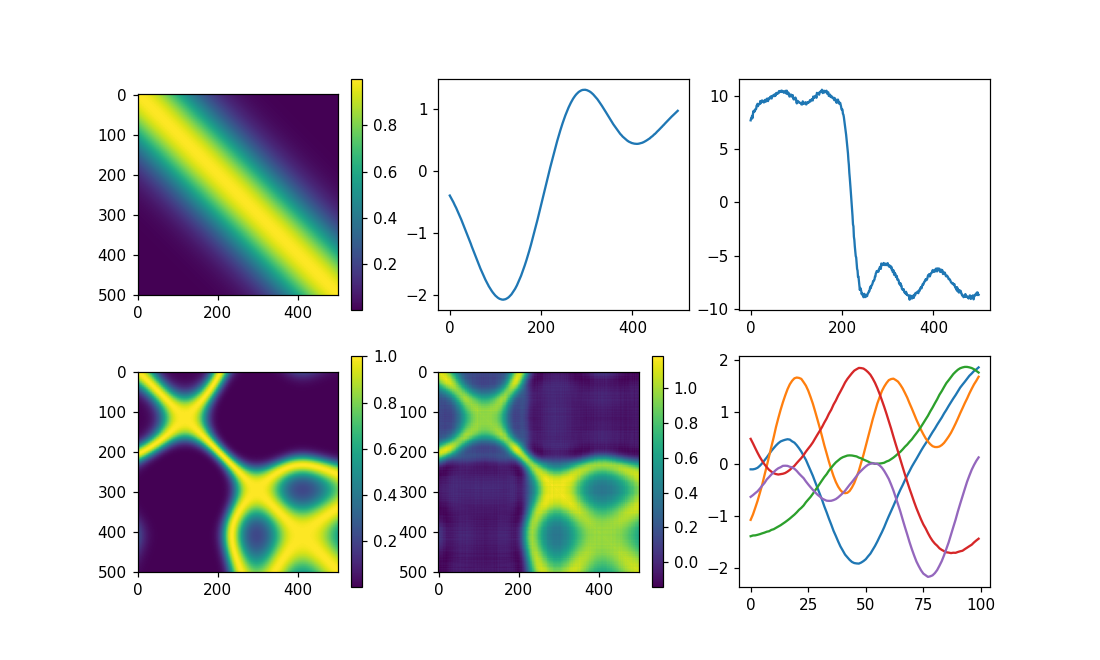

Number of data points N=500
Number of features D=200
Number of latent dimensions K=1


In [3]:
data = scipy.io.loadmat('syn.mat')
x_true = data['x_true']
xgrid = data['xgrid']
z_true = data['z_true']
zgrid = data['zgrid']
tgrid = data['tgrid']
Kz_true = data['Kz_true']
Kprior_true = data['Kprior_true']

N = x_true.shape[0]
D = x_true.shape[1]
K = z_true.shape[1]

pca = PCA(n_components=K)
z_init = pca.fit_transform(x_true)

plt.subplots(2,3,figsize=(10,6))
plt.subplot(2,3,1)
plt.imshow(Kprior_true)
plt.colorbar()
plt.subplot(2,3,2)
plt.plot(z_true)

plt.subplot(2,3,4)
plt.imshow(Kz_true)
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(np.cov(x_true))
plt.colorbar()
plt.subplot(2,3,6)
plt.plot(xgrid[:,:5])
plt.subplot(2,3,3)
plt.plot(z_init)

t_train = tgrid
x_train = x_true

print("Number of data points N={}".format(N))
print("Number of features D={}".format(D))
print("Number of latent dimensions K={}".format(K))

In [4]:
def const(x):
    x = tf.constant(x,dtype=tf.float32)
    return x

sig_f = tf.Variable(np.log(1), dtype=tf.float32)
l = tf.Variable(np.log(10), dtype=tf.float32)
# sig_n = tf.Variable(np.log(0.01), dtype=tf.float32)
# sig_f = const(np.log(1))
# l = const(np.log(0.5))
sig_n = const(np.log(1))
prior_sig_n = const(np.log(1))

z = Normal(loc=tf.zeros([K, N]), scale=tf.ones([K, N])*tf.exp(prior_sig_n))
Kernel = rbf(tf.transpose(z),lengthscale=tf.exp(l),variance=tf.exp(sig_f))+tf.exp(sig_n)*tf.eye(N)
x = MultivariateNormalTriL(loc=tf.zeros([D, N]), scale_tril=tf.cholesky(Kernel))

qz = Normal(loc=tf.Variable(tf.ones([K, N])*1e-2),
            scale=tf.square(tf.Variable(tf.ones([K, N])*1e-2)))
# qz = Normal(loc=tf.Variable(z_init.T,dtype=tf.float32),
#             scale=tf.square(tf.Variable(tf.ones([K, N])*1e-2)))

inference = ed.KLqp({z: qz}, data={x: x_train.T})
inference.run(n_iter=2000, n_print=10, n_samples=10)
  

2000/2000 [100%] ██████████████████████████████ Elapsed: 530s | Loss: 97837.352


In [5]:
# sess = ed.get_session()
# qz_mean, qz_var, sig_f_est, sig_n_est, l_est = sess.run([qz.mean(),qz.variance(),sig_f,sig_n,l],feed_dict={x: x_train.T})
# print("sig_f_est=", "{:.9f}".format(np.exp(sig_f_est)), "sig_n_est=", "{:.9f}".format(np.exp(sig_n_est))
#       , "l_est=", "{:.9f}".format(np.exp(l_est)))

# sig_f = const(sig_f_est)
# l = const(l_est)
# # sig_n = tf.Variable(np.log(1), dtype=tf.float32)
# sig_n = const(np.log(0.1))

# tg = const(tgrid)
# Kprior = rbf(tg,lengthscale=tf.exp(prior_l),variance=tf.exp(prior_sig_f))+tf.exp(prior_sig_n)*tf.eye(N)
# z = MultivariateNormalTriL(loc=tf.zeros([K, N]), scale_tril=tf.cholesky(Kprior))
# Kernel = rbf(tf.transpose(z),lengthscale=tf.exp(l),variance=tf.exp(sig_f))+tf.exp(sig_n)*tf.eye(N)
# x = MultivariateNormalTriL(loc=tf.zeros([D, N]), scale_tril=tf.cholesky(Kernel))

# qz = Normal(loc=tf.Variable(qz_mean,dtype=tf.float32),
#             scale=tf.Variable(qz_var,dtype=tf.float32))

# inference = ed.KLqp({z: qz}, data={x: x_train.T})
# inference.run(n_iter=1000, n_print=10, n_samples=10)
  

sig_f_est= 0.996047795 sig_n_est= 1.000000000 l_est= 0.509890735


<IPython.core.display.Javascript object>


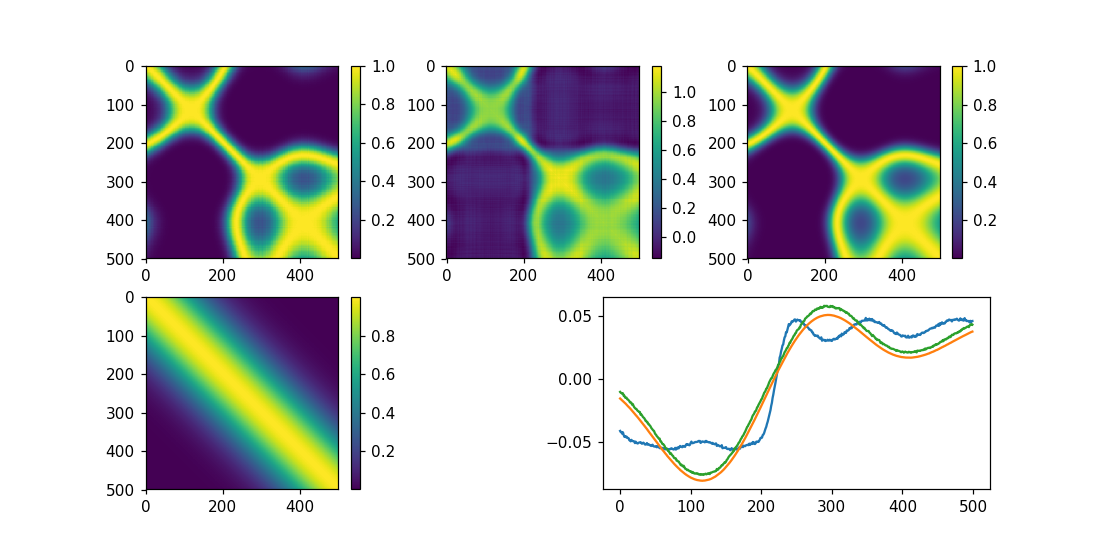

In [6]:
sess = ed.get_session()
qz_mean, qz_var, sig_f_est, sig_n_est, l_est = sess.run([qz.mean(),qz.variance(),sig_f,sig_n,l],feed_dict={x: x_train.T})
print("sig_f_est=", "{:.9f}".format(np.exp(sig_f_est)), "sig_n_est=", "{:.9f}".format(np.exp(sig_n_est))
      , "l_est=", "{:.9f}".format(np.exp(l_est)))
qz_mean = qz_mean.T
Kz = rbf(const(qz_mean),lengthscale=tf.exp(l_est),variance=tf.exp(sig_f_est)).eval()
Kz = Kz/np.amax(Kz)

def match_z(x,z):
    cp = np.corrcoef(x.T,z.T)[0,1]
    cn = np.corrcoef(-x.T,z.T)[0,1]
    if cp<cn:
        return -x
    else:
        return x
    
plt.subplots(2,3,figsize=(10,5))
plt.subplot(2,3,1)
plt.imshow(Kz)
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(np.cov(x_true))
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(Kz_true)
plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(Kprior_true)
plt.colorbar()
plt.subplot(2,2,4)
plt.plot(match_z(z_init/np.linalg.norm(z_init),z_true/np.linalg.norm(z_true)))
plt.plot(z_true/np.linalg.norm(z_true))
plt.plot(match_z(qz_mean/np.linalg.norm(qz_mean),z_true/np.linalg.norm(z_true)))
